In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [257]:
# %% Morp Registration
from importlib import reload
import os
import random

import nibabel as nib
import cv2
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.morphology as morp
import skimage.measure as meas
from scipy.ndimage import rotate
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import trimesh

import general.utils as u
import general.array_morphology as am
import ssm.icp as icp
import ssm.dijkstra as dij

def reload_modules():
    for modl in [u, am, icp, dij]:
        reload(modl)

reload_modules()

In [3]:
%matplotlib notebook

# 0) Sampling

In [403]:
reload_modules()
def create_grid_graph(W, H):
    graph = dij.Graph()

    for i in range(1, W - 1):
        for j in range(1, H - 1):
            if (i, j) in graph.nodes:
                continue
            graph.add_node((i, j))
            for (k1, k2) in [(-1, 0), (1, 0), (0, 1), (0, -1),]:
                graph.add_node((i + k1, j + k2))
                value = 1
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
            for (k1, k2) in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                graph.add_node((i + k1, j + k2))
                value = np.sqrt(2)
                graph.add_edge((i, j), (i + k1, j + k2), value)
                graph.add_edge((i + k1, j + k2), (i, j), value)
                             
    return graph

In [404]:
n = 100
graph = create_grid_graph(n, n)

In [405]:
%%time
reload_modules()
visited, path = dij.dijsktra(graph, [(n//2, n//2)])

CPU times: user 3.09 s, sys: 0 ns, total: 3.09 s
Wall time: 3.08 s


<IPython.core.display.Javascript object>


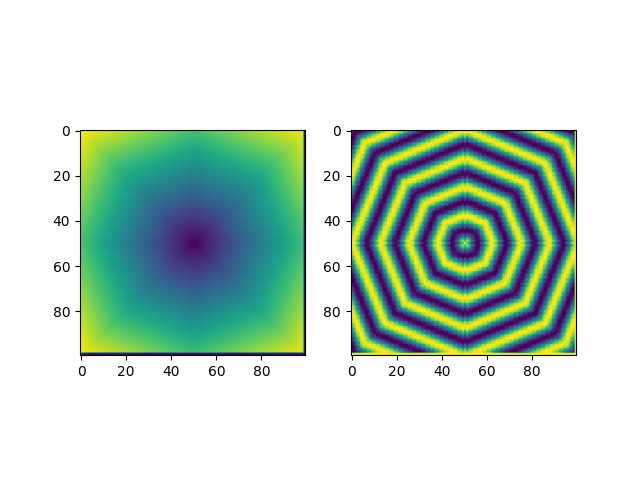

In [406]:
fig, axs = plt.subplots(1, 2)

points = []
ar = np.zeros((n, n))
for (i, j) in visited:
    ar[i, j] = visited[(i, j)]

axs[0].imshow(ar)
axs[1].imshow(np.cos(.5 * ar))


In [175]:
%%time
path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=4)
print(len(verts1), len(faces1))

2772 5540


<IPython.core.display.Javascript object>


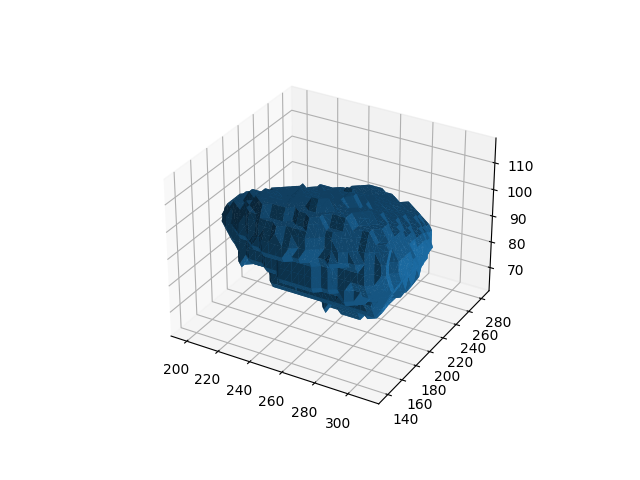

In [174]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)


In [187]:
%%time
gmesh = dij.Graph()
for tri in faces1:
    for i in range(2):
        for j in range(i + 1, 3):
            gmesh.add_node(tri[i])
            gmesh.add_node(tri[j])
            value = np.linalg.norm(verts1[tri[i]] - verts1[tri[j]])
            gmesh.add_edge(tri[i], tri[j], value)
            gmesh.add_edge(tri[j], tri[i], value)
    

CPU times: user 136 ms, sys: 130 ms, total: 266 ms
Wall time: 163 ms


In [222]:
%%time
reload_modules()
visited, path = dij.dijsktra(gmesh, initial_set=[0])

CPU times: user 149 ms, sys: 4.12 ms, total: 153 ms
Wall time: 151 ms


In [223]:
ar_dist = np.zeros(len(visited))
for key, value in visited.items():
    ar_dist[key] = value

In [316]:
%%time
n_points = 100
cur_point = 0

all_points = [cur_point]
for _ in tqdm(range(1, n_points)):
    visited, path = dij.dijsktra(gmesh, initial_set=all_points)
    ar_dist = np.zeros(len(visited))
    for key, value in visited.items():
        ar_dist[key] = value
    cur_point = ar_dist.argmax()
    all_points.append(cur_point)

100%|██████████| 99/99 [00:31<00:00,  3.19it/s]

CPU times: user 31.1 s, sys: 10.4 ms, total: 31.1 s
Wall time: 31 s


<IPython.core.display.Javascript object>


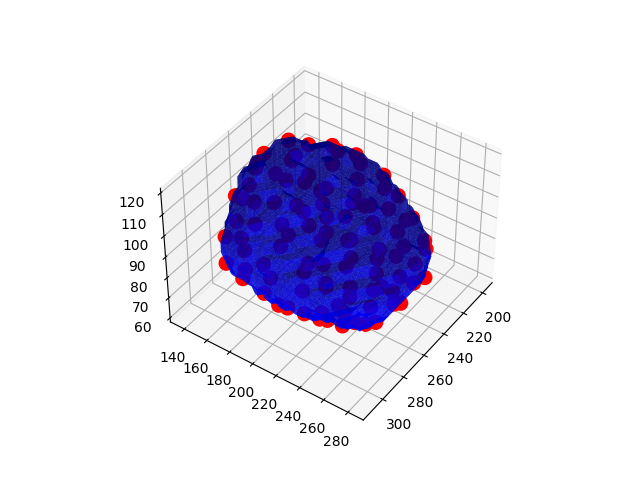

In [317]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color_faces = np.hstack([
    ar_dist[faces1].mean(1),
    ar_dist[faces1].mean(1),
    ar_dist[faces1].mean(1)
]).T

# m = plt.cm.ScalarMappable(norm=color_faces, cmap='jet')
# m.set_array([])
# fcolors = m.to_rgba(color_dimension)

ax.plot_trisurf(*verts1.T, triangles=faces1, color=[0, 0, 1], alpha=.7)
ax.scatter(*verts1[all_points].T, c='r', s=100, alpha=1)


In [252]:
len(ar_dist[faces1].mean(1))


5540

In [ ]:
%%time
msh = trimesh.Trimesh(verts1, faces1, normals1)


In [337]:
mn, mx = ar_dist.min(), ar_dist.max()

for facet in msh.facets:
    grey_value = 100 * (ar_dist[faces1[facet]].mean() - mn) / (mx - mn) + 100
    msh.visual.face_colors[facet] = np.array([
        grey_value, 
        0,
        grey_value, 
        20
    ])


In [338]:
msh.show(alpha=1)

In [267]:
help(msh.show)

Help on method show in module trimesh.base:

show(**kwargs) method of trimesh.base.Trimesh instance
    Render the mesh in an opengl window. Requires pyglet.
    
    Parameters
    ------------
    smooth : bool
      Run smooth shading on mesh or not,
      large meshes will be slow
    
    Returns
    -----------
    scene : trimesh.scene.Scene
      Scene with current mesh in it



# I) Registration

In [23]:
# %%

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-11.nii.gz")
seg1n = nib.load(path_segm)
seg1 = np.round(seg1n.get_fdata()) == 2

path_segm = os.path.abspath("/hdd/datasets/CT-ORG/raw/labels_and_README/labels-10.nii.gz")
seg2n = nib.load(path_segm)
seg2 = np.round(seg2n.get_fdata()) == 2


In [24]:
%%time
reload_modules()
reg1 = (u.get_most_important_regions(seg1) > 0).astype(int)
reg2 = (u.get_most_important_regions(seg2) > 0).astype(int)



CPU times: user 16.5 s, sys: 636 ms, total: 17.2 s
Wall time: 17.2 s


In [25]:
%%time
verts1, faces1, normals1, values1 = meas.marching_cubes(reg1, step_size=4)
verts2, faces2, normals2, values2 = meas.marching_cubes(reg2, step_size=4)


CPU times: user 397 ms, sys: 108 ms, total: 505 ms
Wall time: 503 ms


<IPython.core.display.Javascript object>


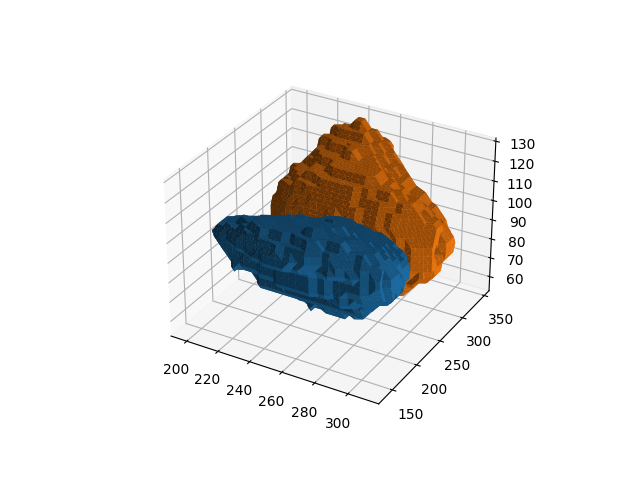

In [26]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(*verts1.T, triangles=faces1)
ax.plot_trisurf(*verts2.T, triangles=faces2)


<IPython.core.display.Javascript object>


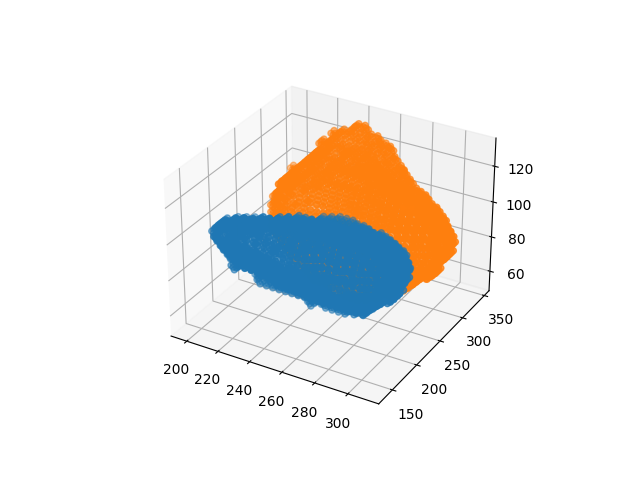

In [27]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*verts1.T,)
ax.scatter(*verts2.T,)


In [28]:
mean1, std1 = verts1.mean(0), verts1.std(0)
mean2, std2 = verts2.mean(0), verts2.std(0)

nverts1 = (verts1 - mean1)/std1
nverts2 = (verts2 - mean2)/std2

<IPython.core.display.Javascript object>


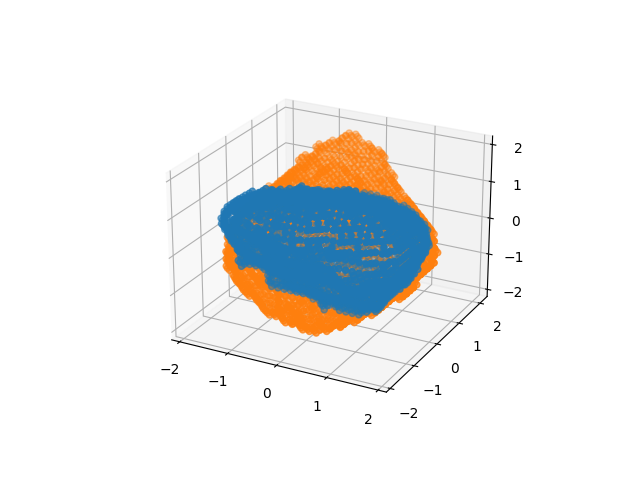

In [29]:
# %%
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*nverts1.T,)
ax.scatter(*nverts2.T,)


In [53]:
%%time
reload_modules()
T, errs, n_iters = icp.icp(nverts1, nverts2, allow_reflection=False, max_iterations=1000, tolerance=1e-5)
print(T, np.max(errs), n_iters)

[[ 0.89120588 -0.15389747  0.42669386 -0.04414943]
 [ 0.4153536  -0.10118469 -0.90401496 -0.13252809]
 [ 0.18230051  0.98289228 -0.02625452 -0.09411046]
 [ 0.          0.          0.          1.        ]] 0.7853241575499997 274
CPU times: user 1.5 s, sys: 2.06 ms, total: 1.5 s
Wall time: 1.5 s


<IPython.core.display.Javascript object>


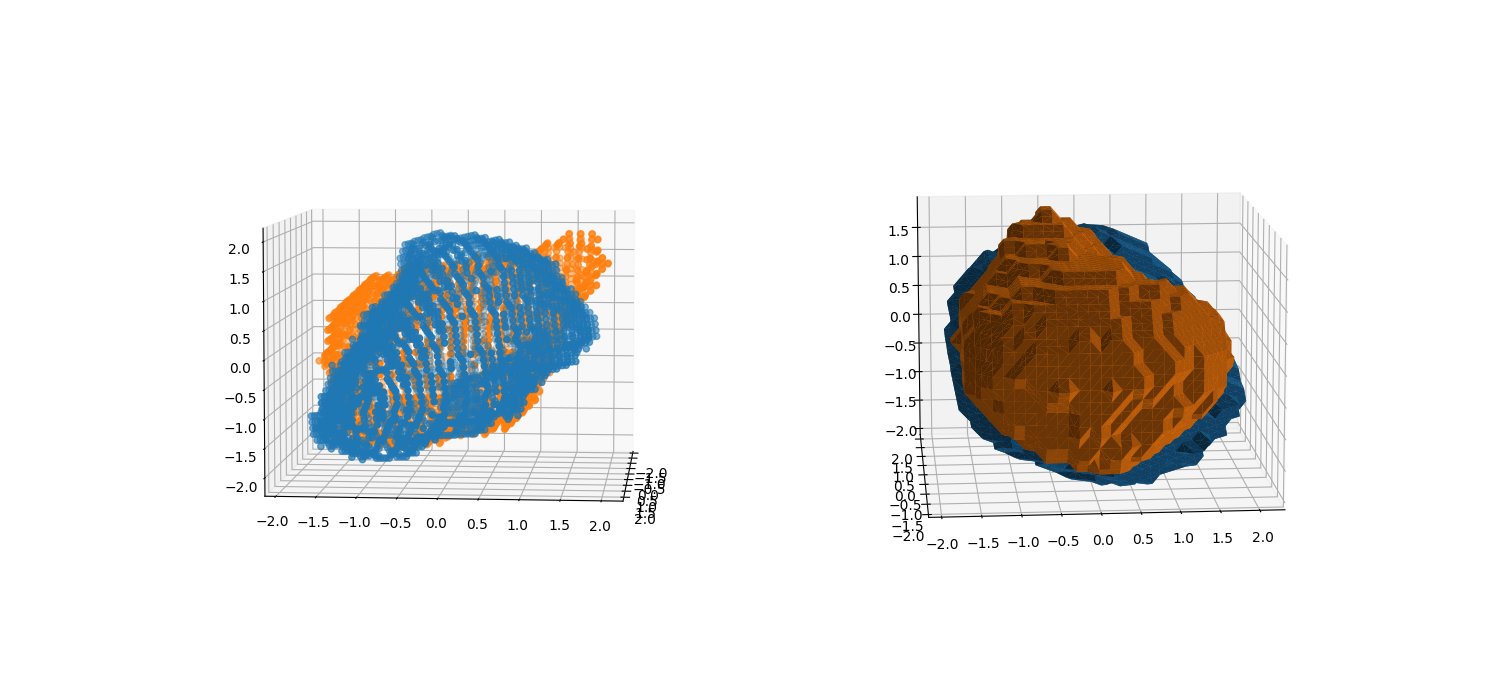

In [54]:
# %%
def transform_cloud(T, mat):
    return ((T @ np.hstack((mat, np.ones((mat.shape[0], 1)))).T).T)[:, :-1]

Tverts1 = transform_cloud(T, nverts1)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(*Tverts1.T,)
ax1.scatter(*nverts2.T,)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(*Tverts1.T, triangles=faces1)
ax2.plot_trisurf(*nverts2.T, triangles=faces2)

In [ ]:
# %%
u.save_as_nii(
    "segmentations/CT_ORG/labels-4-opened.nii.gz",
    reg3,
    seg3n.affine,
    dtype=np.uint8
)


In [19]:
def get_ellipse_fn(center, matrix, radius):
    def fn(*x):
        W, L, H = x[0].shape
        Z = np.zeros_like(x[0])
        for i in range(W):
            for j in range(L):
                for k in range(H):
                    coord = np.array([x[0][i, j, k], x[1][i, j, k], x[2][i, j, k]]) - center
                    coord = coord[:, np.newaxis]
                    Z[i, j, k] = np.sqrt( coord.T @ matrix @ coord) - radius
        return Z
    return fn

def get_ellipsoid_points(center, matrix, radius, shape=(40, 40, 40), eps=1e-1):

    XX, YY, ZZ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
    fn_ellipse = get_ellipse_fn(center, matrix, radius)
    lvset = fn_ellipse(XX, YY, ZZ)
    mask = np.zeros_like(lvset)
    mask[(-eps < lvset) & (lvset < eps)] = 1
    Xs, Ys, Zs = np.where(mask)
    return np.concatenate((Xs[:, np.newaxis], Ys[:, np.newaxis], Zs[:, np.newaxis]), axis=1)


In [161]:
%%time
shape = (70, 70, 70)
eps=1e-3

A1= np.array([
    [6, 2, 1],
    [2, 2, 0],
    [1, 0, 1]
])
center1 = np.array([15, 10, 10])
radius1 = 5

ell1 = get_ellipsoid_points(center1, A1, radius1, shape=shape, eps=eps)

A2 = np.array([
    [6, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
center2 = np.array([10, 10, 10])
radius2 = 5

ell2 = get_ellipsoid_points(center2, A2, radius2, shape=shape, eps=eps)

CPU times: user 2.93 s, sys: 10.1 ms, total: 2.94 s
Wall time: 2.94 s


<IPython.core.display.Javascript object>


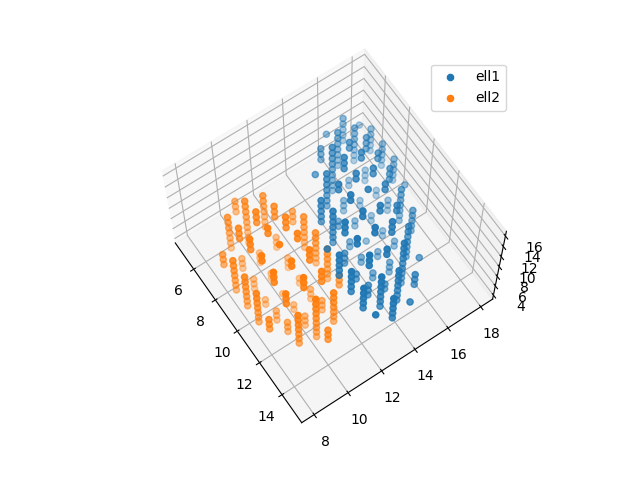

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*ell1.T, label='ell1')
ax.scatter(*ell2.T, label='ell2')
ax.legend()

In [91]:
%%timeit
reload_modules()
T, errs, iters = icp.icp(ell1, ell2, n_points=20)


11.7 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [151]:
all_errs = []
all_errs2 = []
all_n_points = range(1, len(ell1))
T_opt = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, -5],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

for n_pt in tqdm(all_n_points):
    T, errs ,iters = icp.icp(ell1, ell2, n_points=n_pt, max_iterations=1000)
    all_errs.append(np.abs(errs).max())
    all_errs2.append(np.max(T - T_opt))

100%|██████████| 183/183 [00:12<00:00, 15.09it/s]


<IPython.core.display.Javascript object>


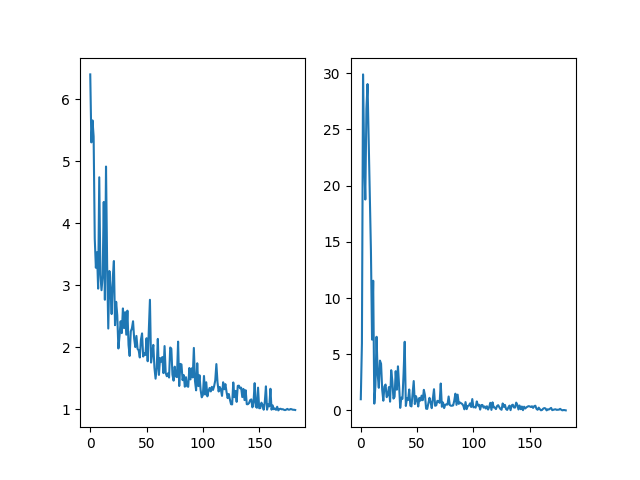

In [152]:
fig, axs = plt.subplots(1, 2)
axs[0].plot(all_errs)
axs[1].plot(all_errs2)

In [121]:
print(T)
print(np.abs(errs).mean())
print(iters)

[[ 1.00000000e+00 -9.90796275e-07 -1.41774147e-06  2.90207983e-05]
 [ 9.89326211e-07  9.99999463e-01 -1.03653054e-03 -4.98964221e+00]
 [ 1.41876770e-06  1.03653054e-03  9.99999463e-01 -2.10099371e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
0.011818425868727712
7


In [163]:
reload_modules()
T, errs, iters = icp.icp(ell1, ell2)
print(T)
print(np.abs(errs).max())
print(iters)

[[ 0.89959054 -0.31147948 -0.30613296  8.77730865]
 [ 0.37209864  0.91361427  0.16386447 -9.0799491 ]
 [ 0.22864702 -0.26132259  0.93777985  2.30011588]
 [ 0.          0.          0.          1.        ]]
1.937060309529838
15


<IPython.core.display.Javascript object>


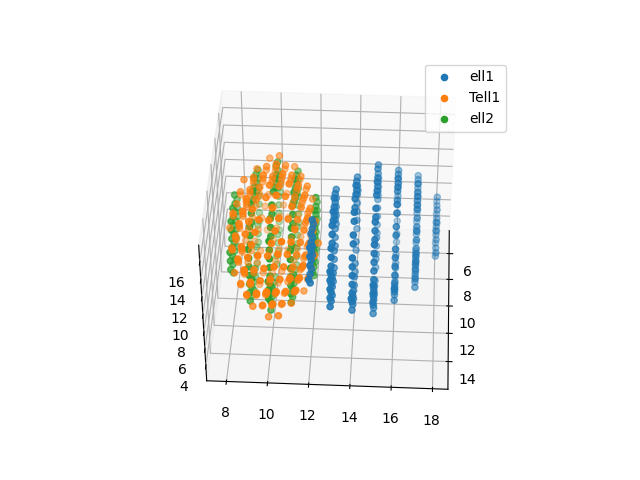

In [164]:
Tell2 = ((T @ np.hstack((ell2, np.ones((ell2.shape[0], 1)))).T).T)[:, :-1]
Tell1 = ((T @ np.hstack((ell1, np.ones((ell1.shape[0], 1)))).T).T)[:, :-1]

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(*ell1.T, label='ell1')
ax1.scatter(*Tell1.T, label='Tell1')
ax1.scatter(*ell2.T, label='ell2')
ax1.legend()

In [35]:
T.shape

(4, 4)

# II) Alignment

# III) Statistics

# IV) Inference